In [2]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import collections
import seaborn as sns
import requests
import json
from urllib.request import urlopen, quote
import math

In [81]:
test_m = pd.read_csv('./data/Master_testset.csv')
train_m = pd.read_csv('./data/Master_trainingset.csv')
test_L = pd.read_csv('./data/Loginfo_testset.csv')
train_L = pd.read_csv('./data/Loginfo_trainingset.csv')
test_U = pd.read_csv('./data/Userinfo_testset.csv')
train_U = pd.read_csv('./data/Userinfo_trainingset.csv')

In [3]:
sns.set(style = 'white', context = 'notebook', palette = 'deep')
sns.set_style('white')
pd.set_option('display.max_columns',400)
pd.set_option('display.max_rows',1000)

### 时间切片，利用登录信息和修改信息衍生特征

选取半年内的时间切片，考虑以月为单位的时间切片，衍生出30天、 60天、 90天、 120天、 150天、 180天等多种时间切片，构造如下计算逻辑：
- 时间切片内的登录的次数
- 时间切片内不同的登录方式的个数
- 时间切片内不同登录方式的平均个数

不同的时间切片与不同的计算逻辑的交互可以产生多个特征。这些特征往往存在一定程度上的线性相关性。在接下来的多变量分析中，需要消除线性相关性对模型产生的影响。

In [88]:
def TimeWindowSelection(df, daysCol, time_windows):
    '''
    :param df: the dataset containg variabel of days
    :param daysCol: the column of days
    :param time_windows: the list of time window
    :return:
    '''
    freq_tw = {}
    for tw in time_windows:
        freq = sum(df[daysCol].apply(lambda x: int(x<=tw)))
        freq_tw[tw] = freq
    return freq_tw

def DeivdedByZero(nominator, denominator):
    '''
    当分母为0时，返回0；否则返回正常值
    '''
    if denominator == 0:
        return 0
    else:
        return nominator*1.0/denominator

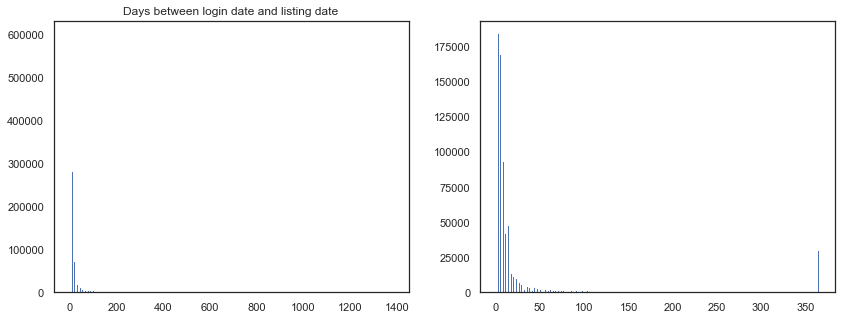

In [86]:
# 查看日期差分布
train_L['logInfo'] = train_L['LogInfo3'].map(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d')) # 转换为datetime   登录时间
train_L['Listinginfo'] = train_L['Listinginfo1'].map(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d')) # 成交时间
train_L['ListingGap'] = train_L[['logInfo','Listinginfo']].apply(lambda x: (x[1]-x[0]).days,axis=1)
ListingGap2 = train_L['ListingGap'].map(lambda x: min(x,365))
plt.figure(figsize=[14,5])
plt.subplot(1,2,1)
plt.hist(train_L['ListingGap'],bins=200);
plt.title('Days between login date and listing date');

plt.subplot(1,2,2)

plt.hist(ListingGap2,bins=200);

In [331]:
timeWindows = TimeWindowSelection(train_L, 'ListingGap', range(30,361,30))
timeWindows

{30: 997517,
 60: 1047156,
 90: 1069691,
 120: 1086399,
 150: 1097773,
 180: 1106160,
 210: 1112483,
 240: 1117434,
 270: 1120878,
 300: 1124427,
 330: 1127686,
 360: 1130501}

In [89]:
test_L['logInfo'] = test_L['LogInfo3'].map(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d')) # 转换为datetime   登录时间
test_L['Listinginfo'] = test_L['Listinginfo1'].map(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d')) # 成交时间

# Log_Info数据集
# 使用180天作为最大的时间窗口计算新特征
# 所有可以使用的时间窗口可以有7 days, 30 days, 60 days, 90 days, 120 days, 150 days and 180 days.
# 在每个时间窗口内，计算总的登录次数，不同的登录方式，以及每种登录方式的平均次数

def Timesplit(train_L,train_U):
    time_window = [7, 30, 60, 90, 120, 150, 180]
    var_list = ['LogInfo1','LogInfo2']  #操作代码 操作类别
    trainLGroupbyIdx = pd.DataFrame({'Idx':train_L['Idx'].drop_duplicates()})

    for tw in time_window:
        train_L['TruncatedLogInfo'] = train_L['Listinginfo'].map(lambda x:x + datetime.timedelta(-tw))
        temp = train_L.loc[train_L['logInfo'] >= train_L['TruncatedLogInfo']]
        for col in var_list:
            #count the frequences of LogInfo1 and LogInfo2
            count_stats = temp.groupby(['Idx'])[col].count().to_dict()
            trainLGroupbyIdx[str(col)+'_'+str(tw)+'_count'] = trainLGroupbyIdx['Idx'].map(lambda x: count_stats.get(x,0))

            # count the distinct value of LogInfo1 and LogInfo2
            Idx_UserupdateInfo1 = temp[['Idx',col]].drop_duplicates()
            uniq_stats = Idx_UserupdateInfo1.groupby(['Idx'])[col].count().to_dict()
            trainLGroupbyIdx[str(col)+'_'+str(tw)+'_unique'] = trainLGroupbyIdx['Idx'].map(lambda x: uniq_stats.get(x,0))

            # calculate the average count of each value in LogInfo1 and LogInfo2
            trainLGroupbyIdx[str(col)+'_'+str(tw)+'_avg_count'] = trainLGroupbyIdx[[str(col)+'_'+str(tw)+'_count',\
                                                    str(col)+'_'+str(tw)+'_unique']].apply(lambda x: DeivdedByZero(x[0],x[1]), axis=1)


    # Userupdate数据集        
    # 在时间切片内，计算
    #  (1) 更新的频率
    #  (2) 每种更新对象的种类个数
    #  (3) 对重要信息如idnumber,hasbuycar,marriagestatusid,phone的更新       
    train_U['ListingInfo'] = train_U['ListingInfo1'].map(lambda x: datetime.datetime.strptime(x,'%Y/%m/%d')) #ListingInfo1：借款成交时间
    train_U['UserupdateInfo'] = train_U['UserupdateInfo2'].map(lambda x: datetime.datetime.strptime(x,'%Y/%m/%d')) # UserupdateInfo2：修改时间
    train_U['ListingGap'] = train_U[['UserupdateInfo','ListingInfo']].apply(lambda x: (x[1]-x[0]).days,axis = 1)
    collections.Counter(train_U['ListingGap'])
    hist_ListingGap = np.histogram(train_U['ListingGap'])
    hist_ListingGap = pd.DataFrame({'Freq':hist_ListingGap[0],'gap':hist_ListingGap[1][1:]})
    hist_ListingGap['CumFreq'] = hist_ListingGap['Freq'].cumsum()  # cumsum():求累计次数
    hist_ListingGap['CumPercent'] = hist_ListingGap['CumFreq'].map(lambda x: x*1.0/hist_ListingGap.iloc[-1]['CumFreq'])

    trainUGroupbyIdx = pd.DataFrame({'Idx':train_U['Idx'].drop_duplicates()})

    for tw in time_window:
        train_U['TruncatedLogInfo'] = train_U['ListingInfo'].map(lambda x: x + datetime.timedelta(-tw))
        temp = train_U.loc[train_U['UserupdateInfo'] >= train_U['TruncatedLogInfo']]

        #frequency of updating
        freq_stats = temp.groupby(['Idx'])['UserupdateInfo1'].count().to_dict()
        trainUGroupbyIdx['UserupdateInfo_'+str(tw)+'_freq'] = trainUGroupbyIdx['Idx'].map(lambda x: freq_stats.get(x,0))

        # number of updated types
        Idx_UserupdateInfo1 = temp[['Idx','UserupdateInfo1']].drop_duplicates()
        uniq_stats = Idx_UserupdateInfo1.groupby(['Idx'])['UserupdateInfo1'].count().to_dict()
        trainUGroupbyIdx['UserupdateInfo_' + str(tw) + '_unique'] = trainUGroupbyIdx['Idx'].map(lambda x: uniq_stats.get(x, 0))

        #average count of each type
        trainUGroupbyIdx['UserupdateInfo_' + str(tw) + '_avg_count'] = trainUGroupbyIdx[['UserupdateInfo_'+str(tw)+'_freq',\
                                             'UserupdateInfo_' + str(tw) + '_unique']].apply(lambda x: DeivdedByZero(x[0],x[1]), axis=1)

        #whether the applicant changed items like idnumber,hasbuycar,marriagestatusid,phone
        Idx_UserupdateInfo1['UserupdateInfo1'] = Idx_UserupdateInfo1['UserupdateInfo1'].map(lambda x: [x])
        Idx_UserupdateInfo1_V2 = Idx_UserupdateInfo1.groupby(['Idx'])['UserupdateInfo1'].sum()
        for item in ['_idnumber','_hasbuycar','_marriagestatusid','_phone']:
            item_dict = Idx_UserupdateInfo1_V2.map(lambda x: int(item in x)).to_dict()
            trainUGroupbyIdx['UserupdateInfo_' + str(tw) + str(item)] = trainUGroupbyIdx['Idx'].map(lambda x: item_dict.get(x, 0))
    return trainLGroupbyIdx,trainUGroupbyIdx


trainLGroupbyIdx,trainUGroupbyIdx = Timesplit(train_L,train_U)
alltrainData = pd.concat([train_m.set_index('Idx'), trainUGroupbyIdx.set_index('Idx'), trainLGroupbyIdx.set_index('Idx')],axis= 1)
alltrainData.to_csv('./data/alltraindata.csv',index=True,encoding = 'gbk')
testLGroupbyIdx,testUGroupbyIdx = Timesplit(test_L,test_U)
alltestData = pd.concat([test_m.set_index('Idx'), testUGroupbyIdx.set_index('Idx'), testLGroupbyIdx.set_index('Idx')],axis= 1)
alltestData.to_csv('./data/alltestdata.csv',index=True)

### 地理位置处理
数据提供了6个与地理位置相关的特征，其中UserInfo_2、 UserInfo_4、 UserInfo_8、 UserInfo_20四个特征为城市信息，UserInfo_7 和 UserInfo_19为省份信息。
- **构建城市差异的特征**：对比不同特征是否相同，比如city_diff24为UserInfo_2、 UserInfo_4两列的城市是否相同

In [90]:
alltrainData['city_allmatch'] = alltrainData.apply(lambda x: int(x.UserInfo_2 == x.UserInfo_4 == x.UserInfo_8 == x.UserInfo_20),axis = 1)

alltrainData['city_diff24'] = alltrainData.apply(lambda x: int(x.UserInfo_2 == x.UserInfo_4),axis = 1)
alltrainData['city_diff28'] = alltrainData.apply(lambda x: int(x.UserInfo_2 == x.UserInfo_8),axis = 1)
alltrainData['city_diff220'] = alltrainData.apply(lambda x: int(x.UserInfo_2 == x.UserInfo_20),axis = 1)
alltrainData['city_diff48'] = alltrainData.apply(lambda x: int(x.UserInfo_4 == x.UserInfo_8),axis = 1)
alltrainData['city_diff420'] = alltrainData.apply(lambda x: int(x.UserInfo_4 == x.UserInfo_20),axis = 1)
alltrainData['city_diff820'] = alltrainData.apply(lambda x: int(x.UserInfo_8 == x.UserInfo_20),axis = 1)

alltrainData['city_diff248'] = alltrainData.apply(lambda x: int(x.UserInfo_2 == x.UserInfo_4 == x.UserInfo_8),axis = 1)
alltrainData['city_diff2420'] = alltrainData.apply(lambda x: int(x.UserInfo_2 == x.UserInfo_4 == x.UserInfo_20),axis = 1)
alltrainData['city_diff2820'] = alltrainData.apply(lambda x: int(x.UserInfo_2 == x.UserInfo_8 == x.UserInfo_20),axis = 1)
alltrainData['city_diff4820'] = alltrainData.apply(lambda x: int(x.UserInfo_4 == x.UserInfo_8 == x.UserInfo_20),axis = 1)

alltestData['city_allmatch'] = alltestData.apply(lambda x: int(x.UserInfo_2 == x.UserInfo_4 == x.UserInfo_8 == x.UserInfo_20),axis = 1)

alltestData['city_diff24'] = alltestData.apply(lambda x: int(x.UserInfo_2 == x.UserInfo_4),axis = 1)
alltestData['city_diff28'] = alltestData.apply(lambda x: int(x.UserInfo_2 == x.UserInfo_8),axis = 1)
alltestData['city_diff220'] = alltestData.apply(lambda x: int(x.UserInfo_2 == x.UserInfo_20),axis = 1)
alltestData['city_diff48'] = alltestData.apply(lambda x: int(x.UserInfo_4 == x.UserInfo_8),axis = 1)
alltestData['city_diff420'] = alltestData.apply(lambda x: int(x.UserInfo_4 == x.UserInfo_20),axis = 1)
alltestData['city_diff820'] = alltestData.apply(lambda x: int(x.UserInfo_8 == x.UserInfo_20),axis = 1)

alltestData['city_diff248'] = alltestData.apply(lambda x: int(x.UserInfo_2 == x.UserInfo_4 == x.UserInfo_8),axis = 1)
alltestData['city_diff2420'] = alltestData.apply(lambda x: int(x.UserInfo_2 == x.UserInfo_4 == x.UserInfo_20),axis = 1)
alltestData['city_diff2820'] = alltestData.apply(lambda x: int(x.UserInfo_2 == x.UserInfo_8 == x.UserInfo_20),axis = 1)
alltestData['city_diff4820'] = alltestData.apply(lambda x: int(x.UserInfo_4 == x.UserInfo_8 == x.UserInfo_20),axis = 1)

- **城市等级合并**：按照城市等级，将城市类别变量合并，一线城市北京、上海、广州、深圳合并，赋值为 1，新一线城市合并为 2，二线城市合并为3，其他城市合并为4

In [92]:
first_tier = ['北京','上海','深圳','广州']
new_first_tier = ['成都','杭州','重庆','武汉','西安','苏州','天津','南京','长沙','郑州','东莞','青岛','沈阳','宁波','昆明','无锡']
second_tier = ['佛山','合肥','大连','福州','厦门','哈尔滨','济南','温州','南宁','长春','泉州','石家庄','贵阳','南昌','金华','常州','南通',\
               '嘉兴','太原','徐州','惠州','珠海','中山','台州','烟台','兰州','绍兴','海口','扬州']

def transtier(x):
    if x in first_tier:
        return 1
    elif x in new_first_tier:
        return 2
    elif x in second_tier:
        return 3
    else:
        return 4

def city_merge(df):
    cols = ['UserInfo_2','UserInfo_4','UserInfo_8','UserInfo_20']  
    for col in cols:
        df[str(col)+'city_tiers'] = df[col].apply(lambda x: transtier(x))
    return df

alltrainData = city_merge(alltrainData)
alltestData = city_merge(alltestData)

In [95]:
alltrainData.to_csv('./data/alltraindata1.csv',index=True,encoding = 'gbk')
alltestData.to_csv('./data/alltestdata1.csv',index=True)

- **城市经纬度转换**：将城市名用经纬度替换，这样就可以将类别型的变量转化为数值型的变量

In [94]:
city_list1 = list(set(list(alltrainData['UserInfo_2'])+list(alltrainData['UserInfo_4'])+list(alltrainData['UserInfo_8'])\
                                        +list(alltrainData['UserInfo_20'])))
city_list2 = list(set(list(alltestData['UserInfo_2'])+list(alltestData['UserInfo_4'])+list(alltestData['UserInfo_8'])\
                                        +list(alltestData['UserInfo_20'])))
city_list = list(set(city_list1+city_list2))
city_list.remove('不详')
# city_list.remove('nan')
city_list = city_list[1:]


url = 'http://api.map.baidu.com/geocoder/v2/'
output = 'json'
ak = 'XeCfCY777qDMTKSqyc3LTiGPnMA7fqzy'
lng_dict = {}
lat_dict = {}

for i in city_list:
    if type(i) == float:
        continue
    else:
        print(i)
        add = quote(i)
        uri = url + '?' + 'address=' + add  + '&output=' + output + '&ak=' + ak #百度地理编码API
        req = urlopen(uri)
        res = req.read().decode()
        temp = json.loads(res)
        lng_dict[i] = temp['result']['location']['lng']
        lat_dict[i] = temp['result']['location']['lat']

拉萨
株洲
上海
汕头
乐山
通化
中卫
娄底
梧州
梅州
阿坝
沧州
昌都
仙桃
乌海
营口
潍坊
大庆
临沂
三门峡
韶关
广州
丽江
绍兴
昭通
徐州
古通辽
宿迁
九江
亳州
贵港
鹰潭
铜川
南昌
黄南藏族自治州
曲靖
怒江傈僳族自治州
白银
鄂州
宜宾
无锡
珠海
阜新
海西蒙古族藏族自治州
松原
内江
石河子
思茅
宝鸡
德州
黑河
古乌海
驻马店
吉林
温州
阜阳
日照
洛阳
抚顺
百色
漯河
海南藏族自治州
阿坝藏族羌族自治州
天津
淮安
六盘水
岳阳
衢州
安顺
本溪
万州
铜仁
咸阳
黄山
广元
宁德
永州
孝感
昌吉回族自治州
资阳
常州
池州
固原
黔南布依族苗族自治州
海拉尔
宁波
绥化
潢川
郴州
泰安
兴安盟
古包头
黔东南苗族侗族自治州
格尔木
晋中
玉林
承德
四平
崇左
淮南
宜昌
渭南
唐山
中山
新余
阳泉
焦作
青岛
珲春
兴义
锡林郭勒盟 锡林浩特
巴音郭楞
防城港
凉山彝族自治州
黔西南布依族苗族自治州
自贡
张家口
沈阳
迪庆藏族自治州
日喀则
林芝
德令哈
钦州
通辽
铁岭
南阳
潜江
萍乡
南平
梅河
海北
伊春
衡阳
邵阳
黔南
吉首
黄石
马鞍山
共和
大兴安岭
邯郸
保定
博尔塔拉蒙古自治州
都匀
西昌
雅安
呼伦贝尔
安康
威海
张掖
廊坊
阿拉善盟
玉树藏族自治州
安庆
朔州
北京
舟山
湘西土家族苗族自治州
运城
常德
汕尾
海北藏族自治州
神农架林区
丽水
澄迈县
聊城
陇南
昆明
呼和浩特
十堰
临汾
楚雄彝族自治州
抚州
白城
长治
锦州
大同
益阳
湛江
湖州
肇庆
双鸭山
濮阳
临河
果洛藏族自治州
包头
黄冈
文山壮族苗族自治州
巴音郭楞蒙古自治州-库尔勒
榆林
丹东
酒泉
南宁
三明
金华
景德镇
平顶山
集宁
清远
济南
延边朝鲜族自治州
遵义
定西
淮北
连云港
乌兰察布盟
周口
湘潭
天水
保山
荆门
那曲
海晏
南充
齐齐哈尔
东方
嘉峪关
成都
来宾
眉山
临夏回族自治州
巢湖
怀化
开封
武汉
漳州
蚌埠
锡林浩特
甘南藏族自治州
三亚
鞍山
西安
宣城
信阳
郑州
佛山
奎屯
扬州
随州
红河哈尼族彝族自治州
许昌
福州
吉安
惠州
达州
晋城
泉州
莆田
辽阳
阿勒泰
汉中
和田
庆阳
哈密
延吉
宜春
泸州
白山
滨州
武威
海东
广安
玉溪
西双版纳傣族自治州
重庆


In [96]:
cols = ['UserInfo_2','UserInfo_4','UserInfo_8','UserInfo_20']
for col in cols:
    alltrainData[col] = alltrainData[col].replace('不详',np.nan)
    alltrainData[col] = alltrainData[col].replace('nan',np.nan)
    alltestData[col] = alltestData[col].replace('不详',np.nan)
    alltestData[col] = alltestData[col].replace('nan',np.nan)

def lng_trans(x):
    if type(x) == str:
        return lng_dict[x]
    else:
        return x

def lat_trans(x):
    if type(x) == str:
        return lat_dict[x]
    else:
        return x
    
def lng_lat(df):
    cols = ['UserInfo_2','UserInfo_4','UserInfo_8','UserInfo_20']  
    for col in cols:
        df[str(col)+'_lng'] = df[col].apply(lambda x: lng_trans(x))
        df[str(col)+'_lat'] = df[col].apply(lambda x: lat_trans(x))
    return df

alltrainData = lng_lat(alltrainData)
alltestData = lng_lat(alltestData)

In [98]:
alltrainData.to_csv('./data/alltraindata3.csv',index=True,encoding = 'gbk')
alltestData.to_csv('./data/alltestdata3.csv',index=True)